# Hodgkin-Huxley

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from seaborn import despine
from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

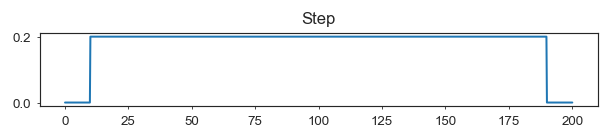

In [6]:
from neuroprobnum.utils import stim_utils
t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stim = stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step')
neuron.get_Istim_at_t = stim.get_I_at_t
stim.plot(t0=t0, tmax=tmax)

# Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
    
gen = DataGeneratorHH(
    t0=t0, tmax=tmax, t_eval_adaptive=math_utils.t_arange(t0, tmax, 5),
    return_vars=['events', 'ys'],
    model=neuron, y0=neuron.compute_yinf(-65), thresh=0.0,
    n_samples=20, n_parallel=20,
    gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
    base_folder='data/examples_hh'
)
gen.update_subfoldername(stim=stim.name)
gen.load_acc_sols_from_file()

Not acc sols file found!


## Data

In [8]:
# pert_method, adaptive, methods, step_params, pert_param
solver_params = [
    ('abdulle_ln', 0, ['EE'], [0.25], [1]),
]

In [9]:
np.random.seed(42)
  
for pert_method, adaptive, methods, step_params, pert_params in solver_params:
    for step_param, method, pert_param in itproduct(step_params, methods, pert_params):
        gen.gen_and_save_data(
            method=method, adaptive=adaptive, step_param=step_param,
            pert_method=pert_method, pert_param=pert_param, overwrite=True, allowgenerror=False,
        )

             stim_Step_tmax_200/EE_f(0.25)_abdulle_ln(1).pkl --> Generate data because file was not found.
No suited acc_ts found in 0 acc_ts. Create reference solution!
2 times the following warning: inefficient


# Load data

In [10]:
from neuroprobnum.generator.dataloader import DataLoader

df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, MAEs=False)
df['stimfun'] = stim
df['stim'] = stim.name
df.head()

,acc_events,acc_ts,acc_vs,adaptive,det_events,det_nODEcalls,det_run_time,det_ts,det_vs,events,...,pert_method,pert_param,run_times,step_param,t0,tmax,ts,vs,stimfun,stim
0,"[[11.270881645965629, 23.333899356067246, 34.9...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[-65.0, -64.99992457182115, -64.9998570073335,...",0,"[[11.850855243541666, 25.65387713167099, 38.90...",800.0,0.021538,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[-65.0, -64.99992555291273, -64.9998627013862,...","[[[12.007016188593497, 25.654282196452833, 39....",...,abdulle_ln,1.0,"[0.04915142059326172, 0.02963089942932129, 0.0...",0.25,0.0,200.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[[-65.0, -64.99993881026417, -64.9998622452679...","IStimStep(0.2,t=[10,190])",Step


# Plot

In [11]:
from neuroprobnum.utils.figure_utils import plot_stim, plot_vs, plot_events

def plot_row(axs, data):
    
    assert axs.size == 4, axs.size
    
    stim_ts = np.arange(t0, tmax, 0.01)
    plot_stim(ax=axs[0], ts=stim_ts, stim=[data.stimfun.get_I_at_t(t=t) for t in stim_ts])

    plot_vs(ax=axs[1], ts=data.acc_ts, vs=data.acc_vs, c='k')
    plot_vs(ax=axs[2], ts=data.det_ts, vs=data.det_vs, c='C1')
    plot_events(ax=axs[3], events=data.events, event_traces={'det.': (data.det_events[0], 'C1'), 'ref.': (data.acc_events[0], 'k')})
    
    pltu.make_share_xlims(axs)
    for ax in axs[:-1]:
        ax.set_xlabel(None)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

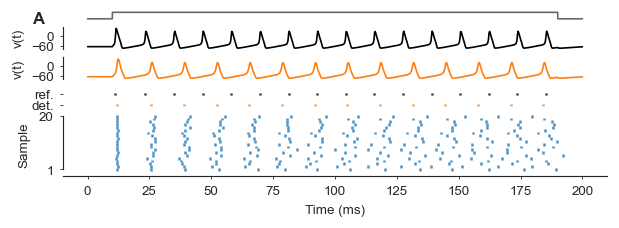

In [12]:
fig, axs = pltu.subplots(1, 4, ysizerow=0.41, yoffsize=0.3, xsize='text', gridspec_kw=dict(height_ratios=[0.08, 0.25, 0.25, 1.0]))
despine()
  
assert len(df) == 1
plot_row(axs=axs, data=df.iloc[0])

# Adjust spacing
mode_spacing = 0.085
plt.tight_layout(h_pad=0.3, rect=[0, 0, 1, 1])    
pltu.set_labs(axs[0], panel_nums='auto', panel_num_space=4, panel_num_va='top', panel_num_y=1.1)
fig.align_labels()

pltu.savefig("fig2_a")
plt.show()

# Text

In [22]:
row = df.iloc[0]

for i in range(3):
    errors = np.array([e_list[0][i] for e_list in row.events]) - row.acc_events[0][i]
    print(f"Mean error of spike {i} = {np.mean(errors):.1f}")

for i in range(3):
    print(f"SD of spike {i} = {np.std([e_list[0][i] for e_list in row.events], ddof=1):.1f}")

Mean error of spike 0 = 0.7
Mean error of spike 1 = 2.8
Mean error of spike 2 = 4.5
SD of spike 0 = 0.2
SD of spike 1 = 0.9
SD of spike 2 = 1.2
